## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Illustrative Experiments on the FERET face recognition dataset showing the connection between LDA and PCA

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import scipy.io as sio
import time
import matplotlib.image as mpimg
import matplotlib as mpl
import os
import pickle
import cv2

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData

##### Preparing matplotlib to genrate high-quality images for the paper

In [3]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 150

##### Setup

In [4]:
C  = 2
K = 10
N_c = [822, 654]
N = np.sum(N_c)
maxVqIteration = 100
width = 384//2
height = 384//2
reg =  10

##### Load dataset

In [5]:
path = '../datasets/feret'
X = np.zeros ([N, height, width])
yTrain = np.zeros (N)

n = 0
for png_obj in os.listdir(path + '/Male'):
    file = os.path.join(path, 'Male',png_obj)
    img = mpimg.imread (file)
    img = cv2.resize(img,(height,width))
    X[n,:,:] = np.mean(img, axis=2)
    yTrain[n] = 0
    n += 1

for png_obj in os.listdir(path + '/Female'):
    file = os.path.join(path, 'Female',png_obj)
    img = mpimg.imread (file)
    img = cv2.resize(img,(height,width))
    X[n,:,:] = np.mean(img, axis=2)
    yTrain[n] = 1
    n += 1

XTrain = X.reshape ([-1, height * width]) - np.mean(X)
XTest = XTrain
yTest = yTrain

##### Prepare data for LDA.

In [6]:
np.random.seed(1)
td = TrainingData(XTrain, yTrain)
clusAlg = sklearn.cluster.KMeans(random_state=1)
clusAlg.max_iter = maxVqIteration
start = time.time()
arrayK = np.ones(C, dtype=int)*K
td.findSubclasses(arrayK, clusAlg)
end = time.time()
print ('Time for clustering: ', end - start)

Time for clustering:  37.01502966880798


##### Show Clustering Result

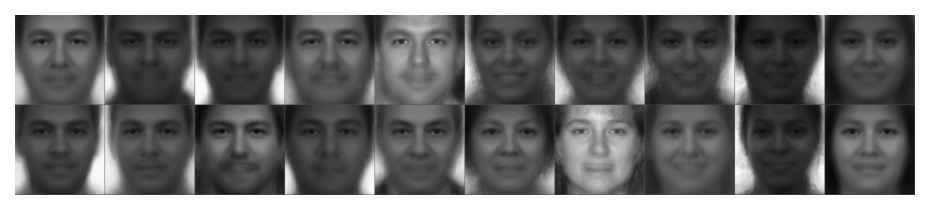

In [7]:
nPicture = 1
nClusterColumns = K // td.C
img = np.zeros ([K*(height+1) // nClusterColumns, nClusterColumns * td.C // nPicture * (width+1) , 3])
nRows = K // nClusterColumns
for c in range(td.C):
    for k in range (td.Ki[c]):
        idx1 = (k % nRows)*(height+1) 
        idx2 = (c * nClusterColumns+ k // nRows) * (width+1)
        img[idx1:idx1+height, idx2:idx2+width, 0] = td.subclassMeans[c,k].reshape ([height,width])
        img[idx1:idx1+height, idx2:idx2+width, 1] = img[idx1:idx1+height, idx2:idx2+width, 0]
        img[idx1:idx1+height, idx2:idx2+width, 2] = img[idx1:idx1+height, idx2:idx2+width, 0]
plt.axis ('off')
#plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout(pad=0)
img = img - np.min(img)
img /= np.max(img)
plt.imshow(img)    
fn = 'feret_clustering_faces' + str((1)) + '.png'
plt.imsave(fn, img)
plt.show()

In [8]:
def performExperiment (solver, metric_learning, reg):
    print ('solver = ', solver, 'metric_learning = ', metric_learning)
    lda = LinearDiscriminantAnalysis(td, solver, metric_learning, 'Sb', 'St', reg, 0.001)
    
    start = time.time()
    lda.fitFeatureExtractor()
    end = time.time()
    print ('lda.fitFeatureExtractor took time: ', end - start)
    return lda

In [9]:
def depictFeatureDetectors(lda, solver, reg, color):
    nClusterColumns = K // td.C
    nPictures = 1
    imgs = lda.GenerateImagesOfLinearFeatureExtractorWeights(width, height, 
                        color = color, nImages = nPicture, rows=K//nClusterColumns, cols = nClusterColumns * C // nPicture)
    for i, img in enumerate (imgs):
        plt.imshow (img)
        plt.axis('off')
        fn = 'feret_{}_reg{}_{}_faces'.format(solver,reg, color) + str((i+1)) + '.png'
        plt.imsave(fn, img)        
        plt.show()

In [10]:
solver = 'ghiasi_svd_pca'
metric_learning = 'none'
reg_pca = performExperiment (solver, metric_learning, reg)

solver =  ghiasi_svd_pca metric_learning =  none
lda.fitFeatureExtractor took time:  30.61348271369934


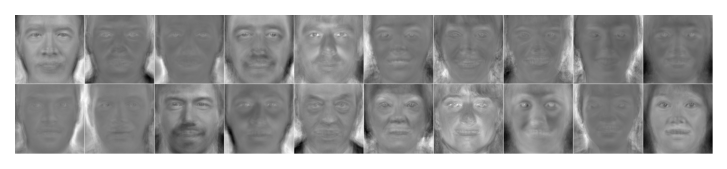

In [11]:
depictFeatureDetectors(reg_pca, solver, reg, 'gray')

### Optional code:

In [12]:
(eigenvec, singval) = reg_pca.S2
for i in range (td.subclassMeans.shape[0]):
    for j in range (td.subclassMeans.shape[1]):
        A =  td.subclassMeans[i,j,:] @ eigenvec
        A = A @ eigenvec.T
        A -= np.min(A)
        A /= np.max(A)    
        plt.imsave(f'png/center_{i}_{j}_original.png', np.reshape(A, [height, width]), cmap='gray')

        A =  td.subclassMeans[i,j,:] @ eigenvec
        A *= np.array(1/singval)
        A = A @ eigenvec.T
        A -= np.min(A)
        A /= np.max(A)
        plt.imsave(f'png/center_{i}_{j}_transformed.png', np.reshape(A, [height, width]), cmap='gray')

In [13]:
(eigenvec, singval) = reg_pca.S2
for n in range (XTrain.shape[0]):
    A =  XTrain[n,:] @ eigenvec
    A = A @ eigenvec.T
    A -= np.min(A)
    A /= np.max(A)    
    plt.imsave(f'png/image_{n}_original.png', np.reshape(A, [height, width]), cmap='gray')
    
    A =  (XTrain[n,:] - td.M) @ eigenvec
    A *= np.array(1/singval)
    A = A @ eigenvec.T
    A -= np.min(A)
    A /= np.max(A)
    plt.imsave(f'png/image_{n}_transformed.png', np.reshape(A, [height, width]), cmap='gray')

### Verifying the equivalence of both viewpoints

In [14]:
(eigenvec, singval) = reg_pca.S2

In [15]:
m = (td.subclassMeans[0,0,:] - td.M) @ eigenvec / np.array(singval) @ eigenvec.T
x = XTest[0,:] @ eigenvec / np.array(singval) @ eigenvec.T
m.T @ x

1.32116333301421

In [16]:
A = (td.subclassMeans[0,0,:] - td.M) @ eigenvec / np.array(singval ** 2) @ eigenvec.T
x = XTest[0,:]  
A.T @ x

1.3211633330142136

#### Note that the value of this feature differs from lda solver due to a normalization there:

A = A.T / np.linalg.norm(A)

In [17]:
solver = 'ghiasi_svd'
metric_learning = 'none'
lda = performExperiment (solver, metric_learning, reg)

solver =  ghiasi_svd metric_learning =  none
lda.fitFeatureExtractor took time:  33.62609052658081


In [18]:
lda.transform(XTest[0,:])

array([ 6.51956006, -0.55636817, -2.51119295, -3.30038404, -4.49582331,
        4.01086354,  6.51526383, -1.90459776, 10.74814846,  4.37350904,
       -1.74296104, -0.29916185, -4.08597893,  8.68368271, -3.65118793,
       -2.89225317, -4.74790468, -5.751379  , -8.85920636,  5.4103879 ])

#### After normalizing we have:

In [19]:
A = (td.subclassMeans[0,0,:] - td.M) @ eigenvec / np.array(singval ** 2) @ eigenvec.T
A = A.T / np.linalg.norm(A)
x = XTest[0,:] 
A.T @ x

6.519560060812112

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>